In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gc
import time
import subprocess
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit import RDConfig
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, rdDistGeom, rdPartialCharges
from rdkit.Chem.AllChem import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2024-10-24 11:09:13.631927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 11:09:13.644197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 11:09:13.647499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 11:09:13.657546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 11:09:14.395359: W tensorflow/compiler/tf2

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

In [5]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1729735756.875225 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735756.911343 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735756.911431 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
target_path = "result/3_solubility_feature_checker"
os.makedirs(target_path, exist_ok=True)

In [7]:
data_ws = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
smiles_ws = data_ws['SMILES']
y_ws = data_ws.iloc[:, 2]

data_delaney = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
smiles_de = data_delaney['smiles']
y_de = data_delaney.iloc[:, 1]

data_lovric2020 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
smiles_lo = data_lovric2020['isomeric_smiles']
y_lo = data_lovric2020.iloc[:, 1]

data_huuskonen = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
smiles_hu = data_huuskonen['SMILES']
y_hu = data_huuskonen.iloc[:, -1].astype('float')

In [8]:
def mol3d(mol):
    mol = Chem.AddHs(mol)
    optimization_methods = [
        (AllChem.EmbedMolecule, (mol, AllChem.ETKDGv3()), {}),
        (AllChem.UFFOptimizeMolecule, (mol,), {'maxIters': 200}),
        (AllChem.MMFFOptimizeMolecule, (mol,), {'maxIters': 200})
    ]

    for method, args, kwargs in optimization_methods:
        try:
            method(*args, **kwargs)
            if mol.GetNumConformers() > 0:
                return mol
        except ValueError as e:
            print(f"Error: {e} - Trying next optimization method [{method}]")

    print(f"Invalid mol for 3d {'\033[94m'}{Chem.MolToSmiles(mol)}{'\033[0m'} - No conformer generated")
    return None

In [9]:
def convert_smiles_to_mol(smiles, fail_folder=None, index=None, yvalue=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"[convert_smiles_to_mol] Cannot convert {smiles} to Mols")
        return None, {"smiles": smiles, "y_value": yvalue, "error": "Invalid SMILES"}

    try:
        Chem.Kekulize(mol, clearAromaticFlags=True)
        isomeric_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol = Chem.MolFromSmiles(isomeric_smiles)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} isomeric_smiles by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"Isomeric SMILES error: {e}"}

    try:
        Chem.SanitizeMol(mol)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} SanitizeMol by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"SanitizeMol error: {e}"}

    return mol, None

In [10]:
def process_smiles(smiles, yvalue, fail_folder, index):
    mol, error = convert_smiles_to_mol(smiles, fail_folder, index, yvalue)
    if error:
        return None, None, error

    mol_3d = mol3d(mol)
    if mol_3d:
        return smiles, yvalue, None
    else:
        img_path = os.path.join(fail_folder, f"mol_{index}.png")
        img = Draw.MolToImage(mol)
        img.save(img_path)
        return None, None, {"smiles": smiles, "y_value": yvalue}

def process_dataset(smiles_list, y_values, dataset_name, target_path="result", max_workers=None):
    start = time.time()
    valid_smiles, valid_y = [], []
    error_smiles_list = []
    fail_folder = f"{target_path}/failed/{dataset_name}"
    os.makedirs(fail_folder, exist_ok=True)

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_smiles, smiles, yvalue, fail_folder, i)
            for i, (smiles, yvalue) in enumerate(zip(smiles_list, y_values))
        ]
        for future in as_completed(futures):
            smiles, yvalue, error = future.result()
            if error:
                error_smiles_list.append(error)
            elif smiles is not None and yvalue is not None:
                valid_smiles.append(smiles)
                valid_y.append(yvalue)

    if error_smiles_list:
        error_df = pd.DataFrame(error_smiles_list)
        error_df.to_csv(os.path.join(fail_folder, "failed_smiles.csv"), index=False)
    print(f" [{dataset_name:<10}] : {time.time()-start:.4f} sec")
    return valid_smiles, valid_y

In [11]:
# smiles_ws, y_ws = process_dataset(smiles_ws, y_ws, "ws496", target_path)
smiles_de, y_de = process_dataset(smiles_de, y_de, "delaney", target_path)
# smiles_lo, y_lo = process_dataset(smiles_lo, y_lo, "Lovric2020_logS0", target_path)
# smiles_hu, y_hu = process_dataset(smiles_hu, y_hu, "huusk", target_path)

 [delaney   ] : 1.4970 sec


In [12]:
LEN_OF_FF = 2048
LEN_OF_MA = 167
LEN_OF_AV = 512

In [13]:
def get_fingerprints(mol):
    if mol is None:
        return None, None, None
    
    morgan_generator = GetMorganGenerator(radius=2, fpSize=LEN_OF_FF)
    ecfp = morgan_generator.GetFingerprint(mol)
    ecfp_array = np.zeros((LEN_OF_FF,),dtype=int)
    DataStructs.ConvertToNumpyArray(ecfp, ecfp_array)
    
    maccs = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)

    avalon_fp = GetAvalonFP(mol)
    avalon_array = np.zeros((LEN_OF_AV,),dtype=int)
    DataStructs.ConvertToNumpyArray(avalon_fp, avalon_array)
    
    return ecfp_array, maccs, avalon_array

def fp_converter(data, use_parallel=True):
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    if use_parallel:
        try:            
            with ProcessPoolExecutor() as executor:
                results = list(executor.map(get_fingerprints, mols))
        except Exception as e:
            print(f"Parallel processing failed due to: {e}. Falling back to sequential processing.")
            use_parallel = False
    
    if not use_parallel:
        results = [get_fingerprints(mol) for mol in mols]
    
    ECFP, MACCS, AvalonFP = zip(*results)
    
    ECFP_container = np.vstack([arr for arr in ECFP if arr is not None])
    MACCS_container = np.zeros((len(MACCS), LEN_OF_MA), dtype=int)
    AvalonFP_container = np.vstack([arr for arr in AvalonFP if arr is not None])

    for i, fp in enumerate(MACCS):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, MACCS_container[i])
    
    return mols, ECFP_container, MACCS_container, AvalonFP_container

In [14]:
# mol_ws, x_ws, MACCS_ws, AvalonFP_ws = fp_converter(smiles_ws)
mol_de, x_de, MACCS_de, AvalonFP_de = fp_converter(smiles_de)
# mol_lo, x_lo, MACCS_lo, AvalonFP_lo = fp_converter(smiles_lo)
# mol_hu, x_hu, MACCS_hu, AvalonFP_hu = fp_converter(smiles_hu)

In [15]:
def concatenate_to_numpy(*dataframes):
    numpy_arrays = [df.to_numpy() if isinstance(df, pd.DataFrame) else df for df in dataframes]
    if not all(isinstance(arr, np.ndarray) for arr in numpy_arrays):
        raise ValueError("All inputs must be either pandas DataFrame or numpy array")
    return np.concatenate(numpy_arrays, axis=1)

In [16]:
try:
    # group_nws = concatenate_to_numpy(x_ws, MACCS_ws, AvalonFP_ws)
    group_nde = concatenate_to_numpy(x_de, MACCS_de, AvalonFP_de)
    # group_nlo = concatenate_to_numpy(x_lo, MACCS_lo, AvalonFP_lo)
    # group_nhu = concatenate_to_numpy(x_hu, MACCS_hu, AvalonFP_hu)
    # del x_ws, MACCS_ws, AvalonFP_ws
    del x_de, MACCS_de, AvalonFP_de
    # del x_lo, MACCS_lo, AvalonFP_lo
    # del x_hu, MACCS_hu, AvalonFP_hu
    gc.collect()
except Exception as e:
    print(f"Error occured: {e}")

In [17]:
BATCHSIZE = 32
EPOCHS = 100
lr = 0.01
decay = 1e-5

In [18]:
def new_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=1024,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(decay)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            units=469,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=regularizers.l2(decay)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1)
        ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.losses.MeanSquaredError(),
                               tf.keras.losses.MeanAbsoluteError(),
                               tf.keras.metrics.RootMeanSquaredError()])
    return model

In [19]:
def save_history_plot(history):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for metric in history.history:
        if metric.startswith('val_'):
            continue
        plt.plot(history.history[metric], label=f'Training {metric}')
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')
    
    plt.title(f'Model Metrics')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    plt.close()

In [20]:
def learning_result(xdata, ydata):
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience=3,
        monitor='val_loss',  
        restore_best_weights=True,
        verbose=1
    )
    def preprocess_data(xtr, ytr):
        dataset = tf.data.Dataset.from_tensor_slices((xtr, ytr))
        dataset = dataset.shuffle(buffer_size=len(xtr)).batch(BATCHSIZE).prefetch(tf.data.AUTOTUNE)
        return dataset
    tf.keras.backend.clear_session()
    xtr, xte, ytr, yte = train_test_split(xdata, ydata, test_size=0.2, random_state=42)
    xtr, xtev, ytr, ytev = train_test_split(xdata, ydata, test_size=0.2, random_state=42)
    model_new = new_model()
    train_data = preprocess_data(xtr, ytr)
    valid_data = preprocess_data(xtev, ytev)
    history = model_new.fit(train_data, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=valid_data,callbacks=[es_callback],verbose=0)
    save_history_plot(history)
    ypred = model_new.predict(xte, verbose=0)
    record = r2_score(ypred, yte)
    tf.keras.backend.clear_session()
    del model_new    
    gc.collect()
    return record
    

In [21]:
def Normalization(descriptor):
    descriptor = np.asarray(descriptor)
    epsilon = 1e-10
    max_value = 1e15
    descriptor = np.clip(descriptor, -max_value, max_value)
    descriptor_custom = np.where(np.abs(descriptor) < epsilon, epsilon, descriptor)
    descriptor_log = np.sign(descriptor_custom) * np.log1p(np.abs(descriptor_custom))
    descriptor_log = np.nan_to_num(descriptor_log, nan=0.0, posinf=0.0, neginf=0.0)
    del epsilon
    gc.collect()    
    return descriptor_log

In [22]:
def process_molecules_parallel(mols, max_workers=4, chunk_size=100):
    results = []    
    for i in range(0, len(mols), chunk_size):
        chunk = mols[i:i + chunk_size]        
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(mol3d, mol) for mol in chunk]
            for future in as_completed(futures):
                result = future.result()
                if result is not None:
                    results.append(result)        
        gc.collect()    
    return results

I0000 00:00:1729735799.412440 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735799.412613 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735799.412671 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735801.046536 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729735801.046864 1177400 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


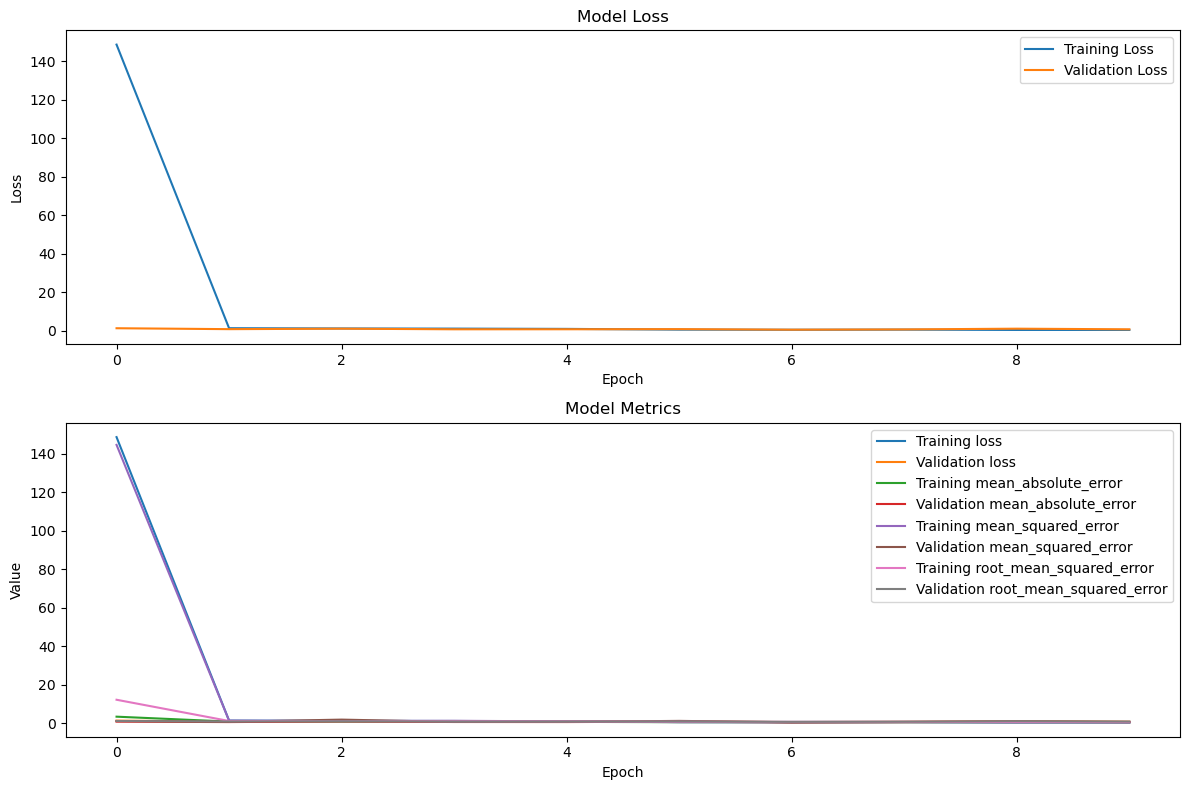

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


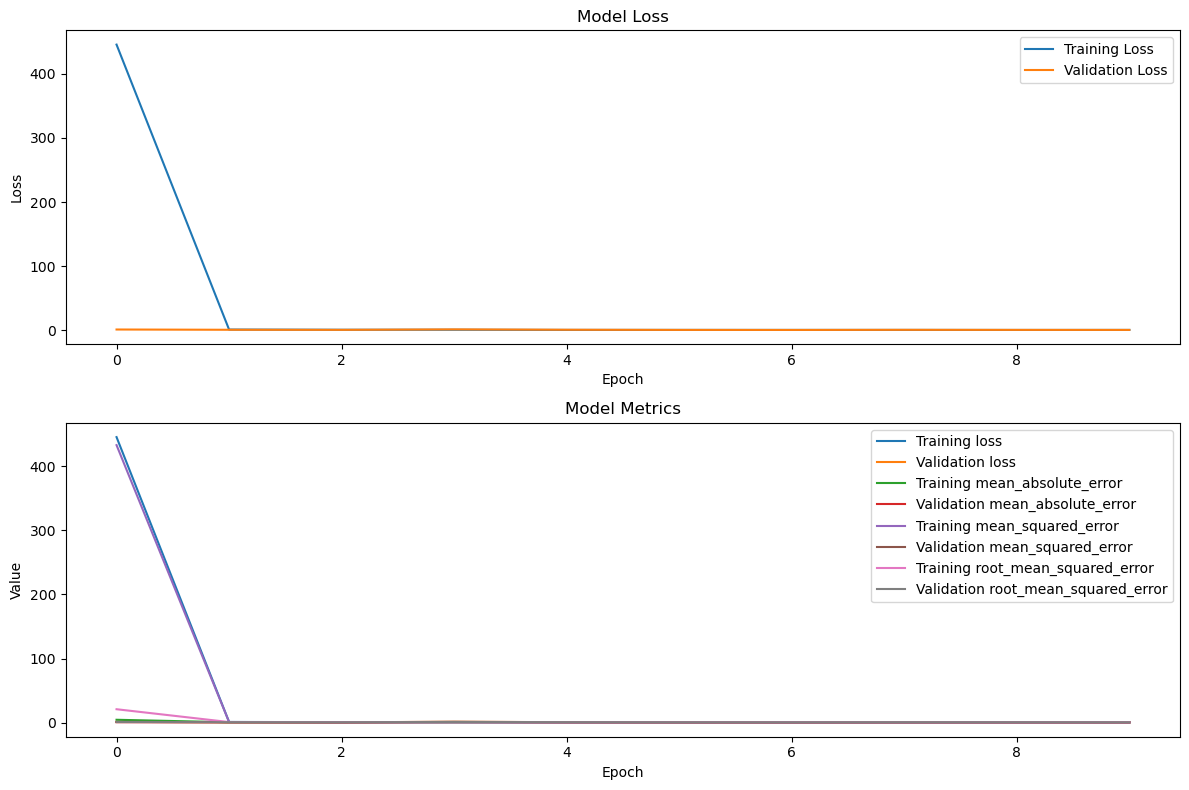

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


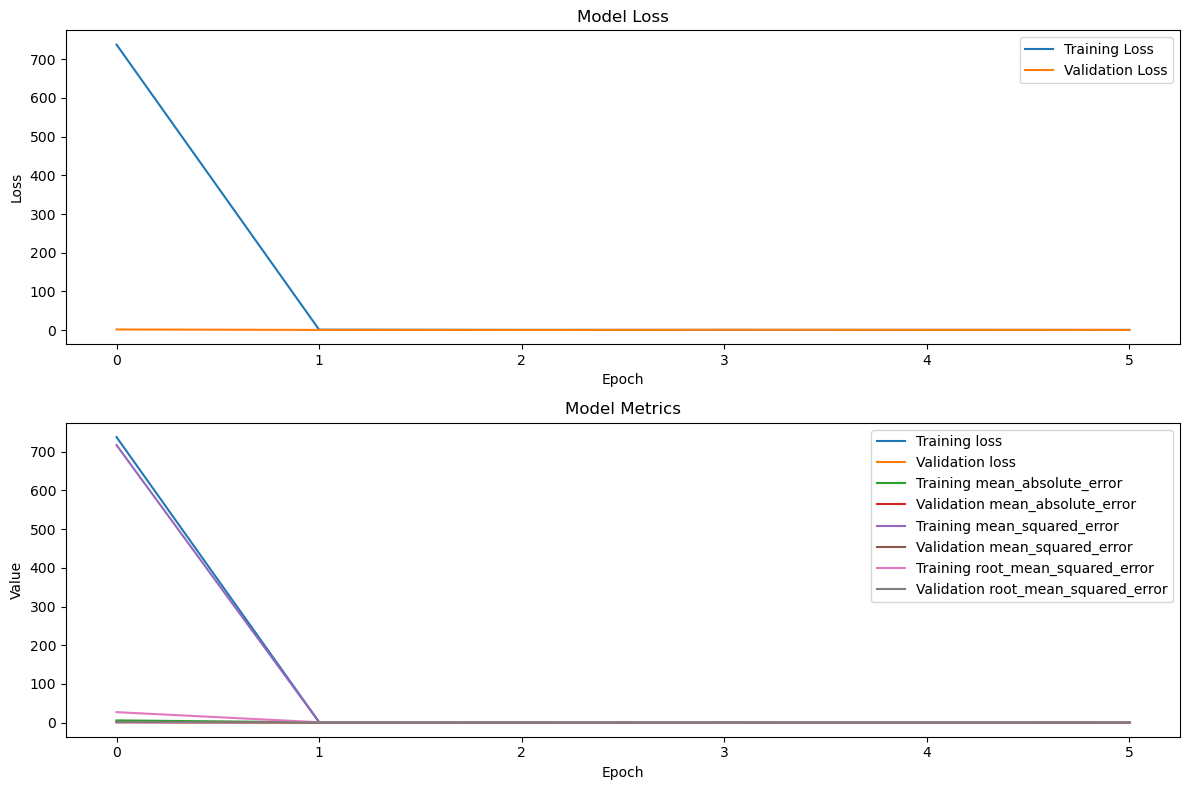

ori     r2score: 0.7219
reshape r2score: 0.7431
:None   r2score: 0.7646


In [24]:
mols = mol_de
mols2 = process_molecules_parallel(mols, max_workers=8)
d1 = [Chem.rdMolDescriptors.CalcPMI1(alpha) for alpha in mols2]
d2 = [Chem.rdMolDescriptors.CalcPMI2(alpha) for alpha in mols2]
d3 = [Chem.rdMolDescriptors.CalcPMI3(alpha) for alpha in mols2]
d1 = Normalization(d1)
d2 = Normalization(d2)
d3 = Normalization(d3)
d1 = np.asarray(d1)
d2 = np.asarray(d2)
d3 = np.asarray(d3)
# ###############
# try:
#     print(type(descriptor),descriptor.shape)
# except:
#     print(type(descriptor),len(descriptor))
# print(f"samples: {descriptor[:5]}")
data = np.column_stack([d1,d2,d3])
descriptor = np.concatenate([group_nde,data], axis=1)
# descriptor = np.asarray(descriptor)
r1 = learning_result(group_nde, y_de)
# new_fps = np.concatenate([group_nde, descriptor.reshape(-1,1)], axis=1)
new_fps = np.concatenate([group_nde, descriptor], axis=1)
new_fps = np.nan_to_num(new_fps, nan=0.0, posinf=0.0, neginf=0.0).astype('float')
r2 = learning_result(new_fps, y_de)
# new_fps = np.concatenate((group_nde, descriptor[:,None]), axis=1)
new_fps = np.concatenate([group_nde, descriptor], axis=1)
new_fps = np.nan_to_num(new_fps, nan=0.0, posinf=0.0, neginf=0.0).astype('float')
r3 = learning_result(new_fps, y_de)
print(f"ori     r2score: {r1:.4f}")
print(f"reshape r2score: {r2:.4f}")
print(f":None   r2score: {r3:.4f}")